In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv("creditcard.csv")

In [13]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, precision_recall_fscore_support
from sklearn.metrics import roc_curve, RocCurveDisplay
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [15]:
features = list(df.columns[:-1])

In [16]:
X = df[features]
y = df['Class']

It's necessary to perform some form of resampling (under-sampling / over-sampling) in order to deal with the imbalanced dataset, else the final model predictions will be heavily skewed. In original dataset there are 284315 observations of class 0 (not fraudulent) and 492 observations of class 1 (fraudulent).

In [17]:
# Undersampling method
undersample = NearMiss(version=1, n_neighbors=3)

In [18]:
# Note: SMOTE seems to not work well with logistic regression, and creates a convergence error. For simplicity I will use under-sampling instead.

# Oversampling method
# SMOTE paper recommends combining SMOTE minority sampling with random undersampling of majority class
#oversample = SMOTE()
#random_under = RandomUnderSampler()
#steps = [('over', oversample), ('random', random_under)]
#pipeline = Pipeline(steps=steps) 

In [19]:
# Avoid introducing any data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
X_train_resample, y_train_resample = undersample.fit_resample(X_train, y_train)
#X_train_resample, y_train_resample = pipeline.fit_resample(X, y)

In [20]:
#scaler = StandardScaler().fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

scaler = StandardScaler().fit(X_train_resample)
X_train_scaled = scaler.transform(X_train_resample)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Making sure decision variables are scaled
for i in range(X_train_scaled.shape[1]):
      print(f"{X_train_scaled[:,i].mean()}\t{X_train_scaled[:,i].std()}")

-1.1722151732082872e-16	1.0
3.60681591756396e-17	1.0
0.0	1.0
0.0	1.0
0.0	1.0
-7.21363183512792e-17	1.0
1.0820447752691881e-16	1.0
0.0	1.0
9.0170397939099e-18	1.0
3.60681591756396e-17	0.9999999999999999
7.21363183512792e-17	1.0
0.0	0.9999999999999999
-7.21363183512792e-17	1.0
1.80340795878198e-17	1.0
7.21363183512792e-17	0.9999999999999998
2.7051119381729703e-17	0.9999999999999999
-3.60681591756396e-17	0.9999999999999999
0.0	0.9999999999999998
3.60681591756396e-17	1.0
-3.60681591756396e-17	0.9999999999999999
-3.60681591756396e-17	1.0
1.80340795878198e-17	1.0
-2.254259948477475e-18	1.0
-1.1271299742387376e-17	1.0
1.80340795878198e-17	0.9999999999999999
0.0	1.0
1.1271299742387376e-17	1.0
2.7051119381729703e-17	0.9999999999999998
1.80340795878198e-17	1.0
1.80340795878198e-17	1.0


In [22]:
# Note: Experiment with C param (inverse of regularization strength) and class_weight param (weights associated wwith classes)
logit = LogisticRegression(class_weight="balanced").fit(X_train_scaled, y_train_resample)
#logit = LogisticRegression(class_weight="balanced").fit(X_train_scaled, y_train)
#logit = LogisticRegression(class_weight={0:0.05, 1:0.95}).fit(X_train_scaled, y_train)

In [23]:
y_prob_pred = logit.predict_proba(X_test_scaled)[:,1]

Optimal threshold:  0.7835865418436233


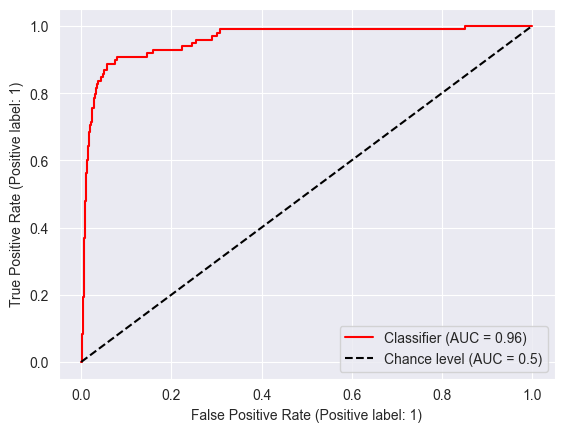

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_pred)
opt_idx = np.argmax(tpr-fpr)
opt_threshold = thresholds[opt_idx]
print("Optimal threshold: ", opt_threshold)
RocCurveDisplay.from_predictions(y_test, y_prob_pred, color="red", plot_chance_level=True)

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_pred)

Text(0.5, 1.0, 'Precision-Recall Curve')

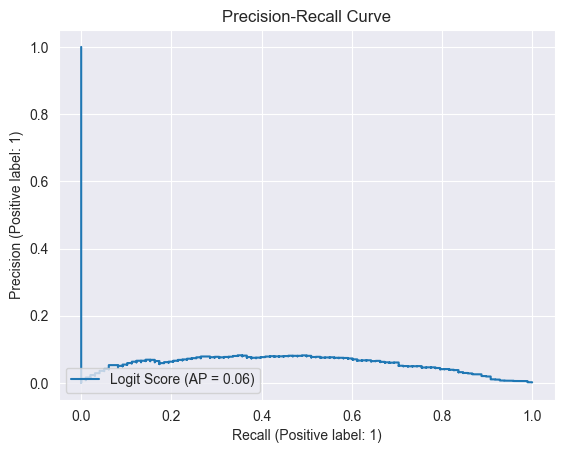

In [26]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_prob_pred, name="Logit Score")
display.ax_.set_title("Precision-Recall Curve")

In [27]:
y_pred = np.array([1 if p > opt_threshold else 0 for p in y_prob_pred])

In [28]:
y_pred.shape

(56962,)

In [29]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')

In [30]:
print(f"Precision: {precision} \n"
      f"Recall: {recall} \n"
      f"Fscore: {fscore} \n"
      f"Support: {support}")

Precision: 0.5125424871157963 
Recall: 0.9096533942783641 
Fscore: 0.509549011671583 
Support: None


After evaluation, our precision is poor and recall is decent. This can indicate that our model is good at predicting the fraud class (i.e, good at identifying true positive) but becomes confused for the non-fraud class (i.e, more instances of false positives). We can try to reduce the undersampling rate, as well as attempt other resampling methods.